<a href="https://colab.research.google.com/github/RitwikRaj29/KMSWT_PROJECT/blob/main/KMSWT_commented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wikipedia-api neptune pandas spacy networkx scipy #installing the dependencies
!pip install SPARQLWrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 19.9 MB/s eta 0:00

In [ ]:
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm
import requests
import csv
from bs4 import BeautifulSoup
import spacy
import pandas as pd
import requests
from spacy import displacy
# import en_core_web_sm
nlp = spacy.load('en_core_web_sm')
 
from spacy.tokens import Span
from spacy.matcher import Matcher
 
import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as nx
from matplotlib import pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON

In [ ]:
!python -m spacy download en

2023-04-17 19:19:00.756236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:


# URL of the Wikipedia page to scrape,we have taken the AI page as refernce
url = 'https://en.wikipedia.org/wiki/Artificial_intelligence'

# Send a GET request to the URL and get the response
response = requests.get(url)

# Create a BeautifulSoup object with the HTML content of the response
soup = BeautifulSoup(response.content, 'html.parser')

# Find all the paragraphs in the page content
paragraphs = soup.find_all('p')

# Create a CSV file to write the sentences into
with open('sentences.csv', mode='w') as csv_file:
    writer = csv.writer(csv_file)
    
    # Loop through each paragraph and split it into sentences
    for paragraph in paragraphs:
        sentences = paragraph.text.split('.')
        
        # Write each sentence into the CSV file
        for sentence in sentences:
            writer.writerow([sentence])


In [ ]:
candidate_sentences = pd.read_csv("/content/sentences.csv")
candidate_sentences.shape

(495, 1)

In [ ]:
candidate_sentences

,\n
0,Artificial intelligence (AI) is intelligence d...
1,Example tasks in which this is done include s...
2,\n
3,AI applications include advanced web search en...
4,g
...,...
490,These were the four the most widely used AI te...
491,Later editions
492,\n
493,The two most widely used textbooks in 2021


In [ ]:
candidate_sentences.set_axis(['sentence'], axis='columns', inplace=True)

<ipython-input-7-ebf8c0a10396>:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  candidate_sentences.set_axis(['sentence'], axis='columns', inplace=True)


In [ ]:
candidate_sentences.head()

,sentence
0,Artificial intelligence (AI) is intelligence d...
1,Example tasks in which this is done include s...
2,\n
3,AI applications include advanced web search en...
4,g


In [ ]:
candidate_sentences['sentence'] = candidate_sentences['sentence'].astype('string') #convert the column's datatype to string
candidate_sentences = candidate_sentences[candidate_sentences['sentence'].notna()] # drop the rows which have null values

In [ ]:
def get_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""
  
   dep_prev_token = "" # dependency tag of previous token in sentence
  
   txt_prev_token = "" # previous token in sentence
  
   prefix = ""
   modifier = ""
  
  
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
      
       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]

In [ ]:
#creation of the (subject,object) pair
entity_pairs = [] 

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 493/493 [00:04<00:00, 101.83it/s]


In [ ]:
entity_pairs[10:20]

[['optical character recognition', 'frequently  things'],
 ['', ''],
 ['academic  it', 'new AI approaches'],
 ['AI research', 'large problem knowledge'],
 ['mathematical machine technique', 'challenging  industry'],
 ['', ''],
 ['fields', 'particular AI tools'],
 ['traditional  goals', 'AI reasoning'],
 ['ability', 'long term goals'],
 ['AI researchers', 'neural  statistics']]

In [ ]:
#function to get the entity relations 
#The predicates are obtained, these are usually verb words
def get_relation(sent):
  
   doc = nlp(sent)
  
   matcher = Matcher(nlp.vocab)
  
   pattern = [{'DEP':'ROOT'},
           {'DEP':'prep','OP':"?"},
           {'DEP':'agent','OP':"?"}, 
           {'POS':'ADJ','OP':"?"}]
  
   matcher.add("matching_1", [pattern])
  
   matcher = matcher(doc)
   h = len(matcher) - 1
  
   span = doc[matcher[h][1]:matcher[h][2]]
  
   return (span.text)

In [ ]:
dummy_sentence = "Fred plays football"
print(get_relation(dummy_sentence))
dummy_sentence_1 = "I drove Joe home because he lives close to my apartment."
print(get_relation(dummy_sentence_1))

plays
drove


In [ ]:
z = list(candidate_sentences['sentence'])
type(z)
relations = []
indx = []
#create the relation for the entity pairs
for i in range(len(z)):
    try:
      relations.append(get_relation(z[i]))
      indx.append(i)
    except:
      continue

In [ ]:
pd.Series(relations).value_counts()[:50]

[                50
is               31
are              12
include           8
argues            6
developed         6
S                 6
argue             5
was               4
used for          3
g                 3
used              3
considers         3
known as          3
became            3
used in           3
need              2
has               2
48                2
use               2
introduced by     2
agreed            2
defines           2
failed            2
inspired by       2
uses              2
called            2
revived by        2
said              2
devised           2
designed          2
began             2
were              2
sought            2
refer to          2
reported          2
U                 2
have              2
be able           2
viewed as         2
is difficult      2
included          2
suggested         2
appeared as       2
started           2
17                2
led               2
began with        2
R                 2
make many         1


In [ ]:
#For the source and target nodes and the edge relation we build the graph
source=[];
target=[];
for i in indx:
  source.append(entity_pairs[i][0])
  target.append(entity_pairs[i][1])
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,Artificial intelligence,humans,is
1,this,other computer inputs,include
2,AI applications,advanced web search engines,include advanced
3,,,g
4,,such recommendation Siri,cars
...,...,...,...
463,,,233
464,These,used AI 2008,were
465,,,editions
466,,used 2021,textbooks in


In [ ]:
# create a directed-graph from a dataframe
import networkx as nx
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

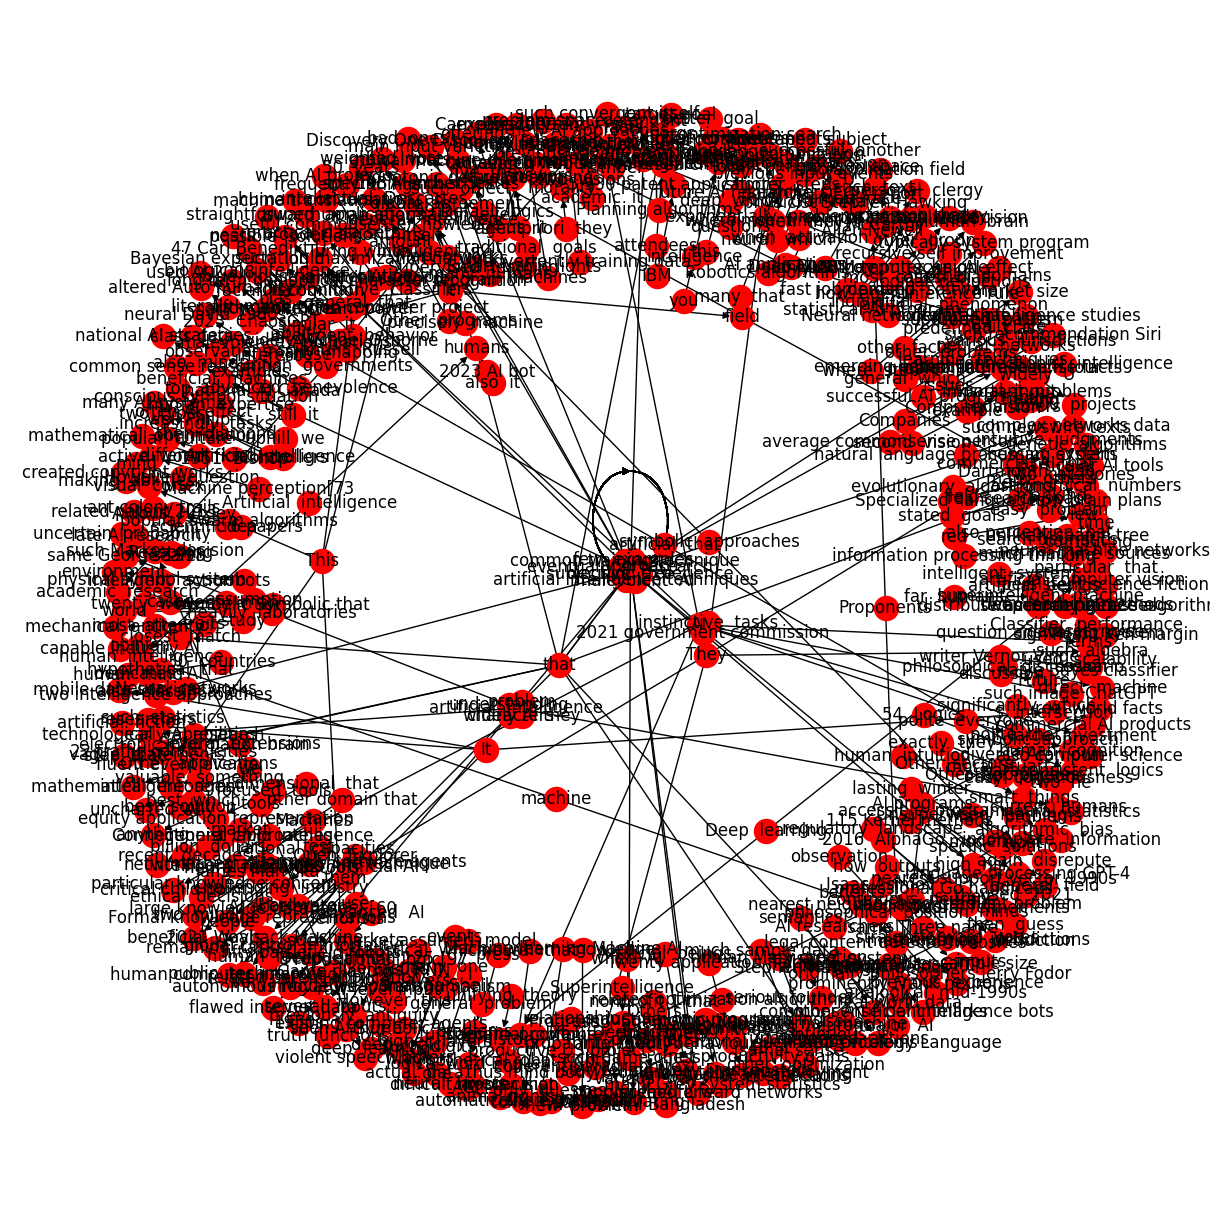

In [ ]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
# Iterate over the entities,predicates and link them to DBpedia
for i in range(len(source)):
    
    entity1 = source[i] #the source entity is assigned
    
    entity2 = target[i] #the target entity is also assigned

    relationship = relations[i]
    # Query DBpedia for candidate entities
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
        SELECT DISTINCT ?s WHERE {{
            ?s rdfs:label "{entity1}"@en.
        }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    if len(results['results']['bindings'])>0:
      print(entity1,'-----> ',results['results']['bindings'][0]['s']['value'])
   
    query = f"""
        SELECT DISTINCT ?s WHERE {{
            ?s rdfs:label "{entity2}"@en.
        }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    if len(results['results']['bindings'])>0:
      print(entity2,'-----> ',results['results']['bindings'][0]['s']['value'])
    

    query = f"""
        SELECT DISTINCT ?s WHERE {{
            ?s rdfs:label "{relationship}"@en.
        }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    if len(results['results']['bindings'])>0:
      print(relationship,'-----> ',results['results']['bindings'][0]['s']['value'])
      print("Relationship")
    
    
type(results)

is ----->  http://dbpedia.org/property/is
Relationship
this ----->  http://dbpedia.org/property/this
AI applications ----->  http://dbpedia.org/resource/AI_applications
g ----->  http://dbpedia.org/property/g
Relationship
cars ----->  http://dbpedia.org/property/cars
Relationship
g ----->  http://dbpedia.org/property/g
Relationship
, ----->  http://dbpedia.org/resource/,
Relationship
founded as ----->  http://dbpedia.org/property/foundedAs
Relationship
AI research ----->  http://dbpedia.org/resource/AI_research
fields ----->  http://dbpedia.org/property/fields
adapted ----->  http://dbpedia.org/property/adapted
Relationship
AI ----->  http://dbpedia.org/resource/AI
it ----->  http://dbpedia.org/property/it
founded on ----->  http://dbpedia.org/property/foundedOn
Relationship
U ----->  http://dbpedia.org/resource/U
Relationship
R ----->  http://dbpedia.org/resource/R
Relationship
characters ----->  http://dbpedia.org/property/characters
17 ----->  http://dbpedia.org/resource/17
Relation

dict